In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from src.data.load_data import load_raw_data
from src.data.data_profiler import check_data
import polars as pl

df_January = load_raw_data(year=2022, month=1)
df_February = load_raw_data(year=2022, month=2)
df_March = load_raw_data(year=2022, month=3)
df_April = load_raw_data(year=2022, month=4)
df_May = load_raw_data(year=2022,month=5)
df_June  = load_raw_data(year=2022, month=6)
df_July = load_raw_data(year=2022, month=7)
df_August = load_raw_data(year=2022, month=8)
df_September  = load_raw_data(year=2022, month=9)
df_October  = load_raw_data(year=2022, month=10)
df_November = load_raw_data(year=2022, month=11)
df_December = load_raw_data(year=2022, month=12)

In [5]:
dfs = [
    df_January, df_February, df_March, df_April, df_May, df_June,
    df_July, df_August, df_September, df_October, df_November, df_December
]

df_full = pl.concat(dfs)

In [6]:
check_data(df_full)



╔══════════════════════════════════════════════════════════╗
║               DATA PROFILING REPORT                      ║
╚══════════════════════════════════════════════════════════╝


  БАЗОВАЯ ИНФОРМАЦИЯ

Размер датасета:
  Строк: 5,667,717
  Колонок: 13
  Размер в памяти: 742.51 MB

Типы данных:
  Datetime(time_unit='us', time_zone=None): 2 колонок
  Float64: 4 колонок
  String: 7 колонок

Колонки:
   1. ride_id                        (String)
   2. rideable_type                  (String)
   3. started_at                     (Datetime(time_unit='us', time_zone=None))
   4. ended_at                       (Datetime(time_unit='us', time_zone=None))
   5. start_station_name             (String)
   6. start_station_id               (String)
   7. end_station_name               (String)
   8. end_station_id                 (String)
   9. start_lat                      (Float64)
  10. start_lng                      (Float64)
  11. end_lat                        (Float64)
  12. end_lng   

In [7]:
df_raw = df_full.clone()
df_clean = df_full.clone()

In [8]:
#длительность поездки в минутах
df_clean = df_clean.with_columns(
    ((pl.col("ended_at") - pl.col("started_at")).dt.total_minutes()).alias("duration_minutes")
)

#распределение длительности
print(df_clean["duration_minutes"].describe())
print(df_clean.filter(pl.col("duration_minutes") <= 0).shape) # Отрицательные/нулевые
print(df_clean.filter(pl.col("duration_minutes") > 24*60).shape) # > 1 суток
print(df_clean.filter(pl.col("duration_minutes") < 1).shape) # < 1 минуты (подозрительно короткие)

# Обсуждение с бизнесом/логикой: Какая поездка считается валидной?
# Пример: от 1 минуты до 12 часов (720 минут). Часто используют 24 часа, но 12 часов строже.
df_clean = df_clean.filter(
    (pl.col("duration_minutes") > 1) &
    (pl.col("duration_minutes") < 720)
)
print(f"Удалено по временным аномалиям: {df_raw.shape[0] - df_clean.shape[0]} строк")

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 5.667717e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 18.954111  │
│ std        ┆ 176.126631 │
│ min        ┆ -10353.0   │
│ 25%        ┆ 5.0        │
│ 50%        ┆ 10.0       │
│ 75%        ┆ 18.0       │
│ max        ┆ 41387.0    │
└────────────┴────────────┘
(121089, 14)
(5359, 14)
(121089, 14)
Удалено по временным аномалиям: 229661 строк


In [9]:
#строки с нулевыми координатами
print(df_clean.filter((pl.col("end_lat") == 0) | (pl.col("end_lng") == 0)).shape)

# приблизительные границы рабочей зоны (Чикаго и окрестности).
# На основе процентилей или известных географических границ.
# Например, из данных: start_lat ~ [41.64, 45.63], start_lng ~ [-87.84, -73.79]
# Но -73.79 (Нью-Йорк) - это выброс! Берем более узкие границы.
# Примем для Чикаго: lat [41.6, 42.4], lng [-88.2, -87.5]
valid_lat_range = (41.6, 42.4)
valid_lng_range = (-88.2, -87.5)
df_clean = df_clean.filter(
    pl.col("start_lat").is_between(*valid_lat_range) &
    pl.col("start_lng").is_between(*valid_lng_range) &
    pl.col("end_lat").is_between(*valid_lat_range) &
    pl.col("end_lng").is_between(*valid_lng_range) &
    (pl.col("end_lat") != 0) &
    (pl.col("end_lng") != 0)
)
print(f"Удалено по географическим аномалиям: {df_raw.shape[0] - df_clean.shape[0]} строк (кумулятивно)")

(6, 14)
Удалено по географическим аномалиям: 230209 строк (кумулятивно)


In [10]:
# Связаны ли пропуски с типом самоката?
print(df_clean.group_by("rideable_type").agg(
    pl.col("start_station_name").is_null().mean().alias("null_start_station_rate"),
    pl.col("end_station_name").is_null().mean().alias("null_end_station_rate"),
    pl.count().alias("count")
).sort("count", descending=True))
# ОЧЕНЬ ВАЖНО: Скорее всего, у electric_bike процент пропусков будет ВЫШЕ.
# Это не ошибка, а особенность: electric_bike можно брать и парковать не только на станциях (dockless).

# Есть ли координаты у строк с пропущенными станциями?
# Если координаты есть, но станции нет — это типично для dockless-поездок.
# Если координат тоже нет (для end_lat/lng) — это брак данных.
null_station_with_coords = df_clean.filter(
    (pl.col("start_station_name").is_null()) &
    (pl.col("start_lat").is_not_null()) & (pl.col("start_lng").is_not_null())
).shape
print(f"Пропуск start_station, но координаты есть: {null_station_with_coords[0]} строк")

# Решение: Разделим стратегию для classic/docked и electric bike.
# Для классических и доковых велосипедов станция ОБЯЗАТЕЛЬНА.
df_bad_station = df_clean.filter(
    (pl.col("rideable_type").is_in(["classic_bike", "docked_bike"])) &
    (
        pl.col("start_station_name").is_null() |
        pl.col("start_station_id").is_null() |
        pl.col("end_station_name").is_null() |
        pl.col("end_station_id").is_null()
    )
)
print(f"Поездки classic/docked bike с пропущенными станциями (подлежат удалению): {df_bad_station.shape[0]}")

# Для electric_bike отсутствие станции — допустимо, если есть координаты.
# Удалим только те electric_bike поездки, где нет КООРДИНАТ конца.
df_bad_electric = df_clean.filter(
    (pl.col("rideable_type") == "electric_bike") &
    (pl.col("end_lat").is_null() | pl.col("end_lng").is_null())
)
print(f"Поездки electric_bike с пропущенными координатами конца: {df_bad_electric.shape[0]}")

df_clean = df_clean.filter(
    # Для classic/docked: должны быть все поля станций
    ~(
        (pl.col("rideable_type").is_in(["classic_bike", "docked_bike"])) &
        (
            pl.col("start_station_name").is_null() |
            pl.col("end_station_name").is_null()
        )
    ) &
    # Для всех типов: должны быть координаты конца
    (pl.col("end_lat").is_not_null() & pl.col("end_lng").is_not_null())
)
print(f"Итоговый размер после очистки пропусков: {df_clean.shape}")
print(f"Общее количество удаленных строк на данном этапе: {df_raw.shape[0] - df_clean.shape[0]}")

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_7729/493630919.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count")


shape: (3, 4)
┌───────────────┬─────────────────────────┬───────────────────────┬─────────┐
│ rideable_type ┆ null_start_station_rate ┆ null_end_station_rate ┆ count   │
│ ---           ┆ ---                     ┆ ---                   ┆ ---     │
│ str           ┆ f64                     ┆ f64                   ┆ u32     │
╞═══════════════╪═════════════════════════╪═══════════════════════╪═════════╡
│ electric_bike ┆ 0.283343                ┆ 0.298266              ┆ 2747972 │
│ classic_bike  ┆ 0.0                     ┆ 0.000161              ┆ 2517723 │
│ docked_bike   ┆ 0.0                     ┆ 0.0                   ┆ 171813  │
└───────────────┴─────────────────────────┴───────────────────────┴─────────┘
Пропуск start_station, но координаты есть: 778620 строк
Поездки classic/docked bike с пропущенными станциями (подлежат удалению): 406
Поездки electric_bike с пропущенными координатами конца: 0
Итоговый размер после очистки пропусков: (5437102, 14)
Общее количество удаленных строк на 

In [11]:
print("\n" + "="*60)
print("ОТЧЕТ ПО ОЧИЩЕННЫМ ДАННЫМ")
print("="*60)
check_data(df_clean)
print(f"\nИтоговая доля сохраненных данных: {df_clean.shape[0] / df_raw.shape[0]:.2%}")
print(f"\nРаспределение по типам велосипедов после очистки:")
print(df_clean.group_by("rideable_type").agg(pl.count().alias("count")).sort("count", descending=True))
df_clean.write_parquet("cleaned_scooter_data_2022.parquet")
print("\nОчищенные данные сохранены в 'cleaned_scooter_data_2022.parquet'")


ОТЧЕТ ПО ОЧИЩЕННЫМ ДАННЫМ


╔══════════════════════════════════════════════════════════╗
║               DATA PROFILING REPORT                      ║
╚══════════════════════════════════════════════════════════╝


  БАЗОВАЯ ИНФОРМАЦИЯ

Размер датасета:
  Строк: 5,437,102
  Колонок: 14
  Размер в памяти: 755.33 MB

Типы данных:
  Datetime(time_unit='us', time_zone=None): 2 колонок
  Float64: 4 колонок
  Int64: 1 колонок
  String: 7 колонок

Колонки:
   1. ride_id                        (String)
   2. rideable_type                  (String)
   3. started_at                     (Datetime(time_unit='us', time_zone=None))
   4. ended_at                       (Datetime(time_unit='us', time_zone=None))
   5. start_station_name             (String)
   6. start_station_id               (String)
   7. end_station_name               (String)
   8. end_station_id                 (String)
   9. start_lat                      (Float64)
  10. start_lng                      (Float64)
  11. end_lat    

/var/folders/m_/0vg5klms5wqfl8z1jkpk95tr0000gn/T/ipykernel_7729/732510708.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  print(df_clean.group_by("rideable_type").agg(pl.count().alias("count")).sort("count", descending=True))



Очищенные данные сохранены в 'cleaned_scooter_data_2022.parquet'


In [13]:
def find_nearest_station(df_with_coords, station_ref, max_distance_km=0.2):
    """
    Ищет ближайшую станцию в радиусе max_distance_km.
    Использует приблизительное расстояние (для Чикаго подходит).
    """
    result = []
    
    for row in df_with_coords.iter_rows(named=True):
        min_distance = float('inf')
        nearest_station = None
        nearest_station_id = None
        
        for station in station_ref.iter_rows(named=True):
            # Простое евклидово расстояние (для небольших расстояний в одном городе)
            distance = ((row['start_lat'] - station['avg_lat']) ** 2 + 
                       (row['start_lng'] - station['avg_lng']) ** 2) ** 0.5
            
            # Приблизительный перевод в км (1 градус ≈ 111 км)
            distance_km = distance * 111
            
            if distance_km < min_distance and distance_km < max_distance_km:
                min_distance = distance_km
                nearest_station = station['start_station_name']
                nearest_station_id = station['start_station_id']
        
        result.append({
            'ride_id': row['ride_id'],
            'nearest_station_name': nearest_station,
            'nearest_station_id': nearest_station_id,
            'distance_km': min_distance
        })
    
    return pl.DataFrame(result)

sample_data = df_clean.filter(
    (pl.col("start_station_name").is_null()) &
    (pl.col("rideable_type") == "electric_bike")
).head(1000)

# Находим ближайшие станции
nearest_stations = find_nearest_station(sample_data, station_reference)

print("Распределение найденных расстояний:")
print(nearest_stations.filter(pl.col("nearest_station_name").is_not_null())["distance_km"].describe())
success_rate = nearest_stations.filter(pl.col("nearest_station_name").is_not_null()).shape[0] / nearest_stations.shape[0]
print(f"Успешно привязано: {success_rate:.2%} поездок")

Распределение найденных расстояний:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 716.0    │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.036485 │
│ std        ┆ 0.063672 │
│ min        ┆ 0.0      │
│ 25%        ┆ 0.0      │
│ 50%        ┆ 0.0      │
│ 75%        ┆ 0.062919 │
│ max        ┆ 0.189277 │
└────────────┴──────────┘
Успешно привязано: 71.60% поездок


In [14]:
# Добавляем признак типа поездки
df_clean = df_clean.with_columns([
    pl.when(pl.col("start_station_name").is_not_null() & pl.col("end_station_name").is_not_null())
      .then(pl.lit("station_to_station"))
      .when(pl.col("start_station_name").is_not_null() & pl.col("end_station_name").is_null())
      .then(pl.lit("station_to_dockless"))
      .when(pl.col("start_station_name").is_null() & pl.col("end_station_name").is_not_null())
      .then(pl.lit("dockless_to_station"))
      .otherwise(pl.lit("dockless_to_dockless"))
      .alias("ride_type")
])

print("Распределение по типам поездок:")
print(df_clean.group_by("ride_type").agg(pl.len().alias("count")).sort("count", descending=True))

Распределение по типам поездок:
shape: (4, 2)
┌──────────────────────┬─────────┐
│ ride_type            ┆ count   │
│ ---                  ┆ ---     │
│ str                  ┆ u32     │
╞══════════════════════╪═════════╡
│ station_to_station   ┆ 4222252 │
│ station_to_dockless  ┆ 436230  │
│ dockless_to_station  ┆ 395223  │
│ dockless_to_dockless ┆ 383397  │
└──────────────────────┴─────────┘


Создан справочник 1724 станций
shape: (5, 5)
┌─────────────────────────────────┬──────────────────┬───────────┬────────────┬────────────────┐
│ start_station_name              ┆ start_station_id ┆ avg_lat   ┆ avg_lng    ┆ n_observations │
│ ---                             ┆ ---              ┆ ---       ┆ ---        ┆ ---            │
│ str                             ┆ str              ┆ f64       ┆ f64        ┆ u32            │
╞═════════════════════════════════╪══════════════════╪═══════════╪════════════╪════════════════╡
│ Streeter Dr & Grand Ave         ┆ 13022            ┆ 41.892276 ┆ -87.612064 ┆ 145841         │
│ DuSable Lake Shore Dr & North … ┆ LF-005           ┆ 41.911714 ┆ -87.626825 ┆ 79805          │
│ DuSable Lake Shore Dr & Monroe… ┆ 13300            ┆ 41.880979 ┆ -87.616756 ┆ 78831          │
│ Michigan Ave & Oak St           ┆ 13042            ┆ 41.900966 ┆ -87.623772 ┆ 77667          │
│ Wells St & Concord Ln           ┆ TA1308000050     ┆ 41.912112 ┆ -87.634695 ┆ 72

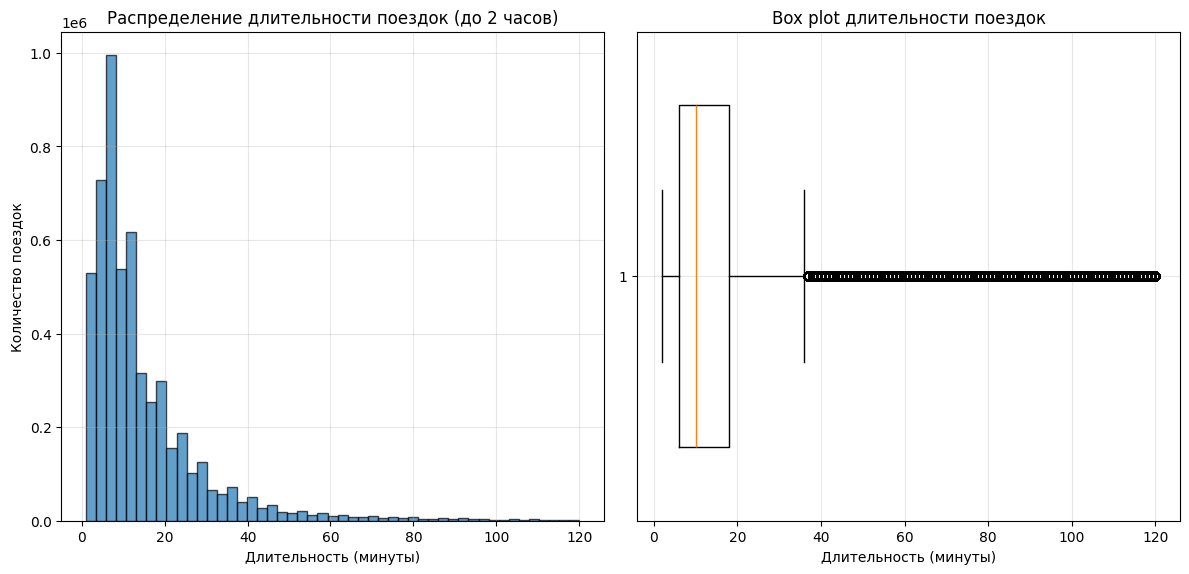


Статистика длительности по типам велосипедов:
shape: (3, 5)
┌───────────────┬───────────────┬─────────────────┬──────────────┬─────────┐
│ rideable_type ┆ mean_duration ┆ median_duration ┆ std_duration ┆ count   │
│ ---           ┆ ---           ┆ ---             ┆ ---          ┆ ---     │
│ str           ┆ f64           ┆ f64             ┆ f64          ┆ u32     │
╞═══════════════╪═══════════════╪═════════════════╪══════════════╪═════════╡
│ electric_bike ┆ 13.663608     ┆ 9.0             ┆ 16.18983     ┆ 2747972 │
│ classic_bike  ┆ 16.583308     ┆ 11.0            ┆ 22.710764    ┆ 2517317 │
│ docked_bike   ┆ 44.95551      ┆ 27.0            ┆ 53.857355    ┆ 171813  │
└───────────────┴───────────────┴─────────────────┴──────────────┴─────────┘

Статистика длительности по типам пользователей:
shape: (2, 5)
┌───────────────┬───────────────┬─────────────────┬──────────────┬─────────┐
│ member_casual ┆ mean_duration ┆ median_duration ┆ std_duration ┆ count   │
│ ---           ┆ ---        

In [20]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

station_reference = df_clean.filter(
    pl.col("start_station_name").is_not_null()
).select([
    "start_station_name",
    "start_station_id",
    pl.col("start_lat").alias("station_lat"),
    pl.col("start_lng").alias("station_lng")
])

# Добавляем конечные станции
end_stations = df_clean.filter(
    pl.col("end_station_name").is_not_null()
).select([
    "end_station_name",
    "end_station_id",
    pl.col("end_lat").alias("station_lat"),
    pl.col("end_lng").alias("station_lng")
]).rename({
    "end_station_name": "start_station_name",
    "end_station_id": "start_station_id"
})

# Объединяем и усредняем координаты
station_reference = pl.concat([station_reference, end_stations], how="diagonal")
station_reference = station_reference.group_by(["start_station_name", "start_station_id"]).agg([
    pl.mean("station_lat").alias("avg_lat"),
    pl.mean("station_lng").alias("avg_lng"),
    pl.len().alias("n_observations")
]).sort("n_observations", descending=True)

print(f"Создан справочник {station_reference.shape[0]} станций")
print(station_reference.head())

def assign_nearest_station(row, stations_df, max_distance_km=0.5):
    """Находит ближайшую станцию для одной строки"""
    if row['start_station_name'] is not None:
        return row['start_station_name'], row['start_station_id']
    
    min_distance = float('inf')
    nearest_station_name = None
    nearest_station_id = None
    
    for station in stations_df.iter_rows(named=True):
        distance = ((row['start_lat'] - station['avg_lat']) ** 2 + 
                   (row['start_lng'] - station['avg_lng']) ** 2) ** 0.5
        
        # Приблизительный перевод в км (1 градус ≈ 111 км)
        distance_km = distance * 111
        
        if distance_km < min_distance and distance_km < max_distance_km:
            min_distance = distance_km
            nearest_station_name = station['start_station_name']
            nearest_station_id = station['start_station_id']
    
    return nearest_station_name, nearest_station_id

sample_data = df_clean.filter(
    (pl.col("start_station_name").is_null()) &
    (pl.col("rideable_type") == "electric_bike")
).head(1000).to_dicts()

assigned_count = 0
for row in sample_data:
    nearest_name, nearest_id = assign_nearest_station(row, station_reference)
    if nearest_name is not None:
        assigned_count += 1

print(f"Успешно привязано станций: {assigned_count}/{len(sample_data)} ({assigned_count/len(sample_data):.1%})")

df_clean = df_clean.with_columns(
    pl.when(
        (pl.col("start_station_name").is_not_null()) & 
        (pl.col("end_station_name").is_not_null())
    ).then(pl.lit("station_to_station"))
    .when(
        (pl.col("start_station_name").is_not_null()) & 
        (pl.col("end_station_name").is_null())
    ).then(pl.lit("station_to_dockless"))
    .when(
        (pl.col("start_station_name").is_null()) & 
        (pl.col("end_station_name").is_not_null())
    ).then(pl.lit("dockless_to_station"))
    .otherwise(pl.lit("dockless_to_dockless"))
    .alias("ride_type")
)

print("\nРаспределение по типам поездок:")
print(df_clean.group_by("ride_type").agg(pl.len().alias("count")).sort("count", descending=True))

# ============================================================================

duration_data = df_clean["duration_minutes"].to_numpy()
duration_filtered = duration_data[(duration_data >= 1) & (duration_data <= 120)]

print(f"\nАнализ длительности:")
print(f"Всего значений: {len(duration_data):,}")
print(f"Отфильтровано (1-120 мин): {len(duration_filtered):,}")
print(f"Минимальная длительность: {duration_filtered.min():.1f} мин")
print(f"Максимальная длительность: {duration_filtered.max():.1f} мин")

if len(duration_filtered) > 0:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    bins = np.linspace(1, 120, 50)
    counts, bins = np.histogram(duration_filtered, bins=bins)
    plt.bar(bins[:-1], counts, width=np.diff(bins), edgecolor='black', alpha=0.7, align='edge')
    plt.title('Распределение длительности поездок (до 2 часов)')
    plt.xlabel('Длительность (минуты)')
    plt.ylabel('Количество поездок')
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 2, 2)
    plt.boxplot(duration_filtered, vert=False, widths=0.7)
    plt.title('Box plot длительности поездок')
    plt.xlabel('Длительность (минуты)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для визуализации длительности")

# Анализ по типам велосипедов
print("\nСтатистика длительности по типам велосипедов:")
duration_stats = df_clean.group_by("rideable_type").agg([
    pl.mean("duration_minutes").alias("mean_duration"),
    pl.median("duration_minutes").alias("median_duration"),
    pl.std("duration_minutes").alias("std_duration"),
    pl.len().alias("count")
]).sort("count", descending=True)
print(duration_stats)

# Анализ по типам пользователей
print("\nСтатистика длительности по типам пользователей:")
member_stats = df_clean.group_by("member_casual").agg([
    pl.mean("duration_minutes").alias("mean_duration"),
    pl.median("duration_minutes").alias("median_duration"),
    pl.std("duration_minutes").alias("std_duration"),
    pl.len().alias("count")
]).sort("count", descending=True)
print(member_stats)


# временные признаки
df_clean = df_clean.with_columns([
    pl.col("started_at").dt.year().alias("year"),
    pl.col("started_at").dt.month().alias("month"),
    pl.col("started_at").dt.day().alias("day"),
    pl.col("started_at").dt.hour().alias("hour"),
    pl.col("started_at").dt.weekday().alias("weekday"),
    
    # Сезонность
    pl.when(pl.col("started_at").dt.month().is_in([12, 1, 2]))
      .then(pl.lit("winter"))
      .when(pl.col("started_at").dt.month().is_in([3, 4, 5]))
      .then(pl.lit("spring"))
      .when(pl.col("started_at").dt.month().is_in([6, 7, 8]))
      .then(pl.lit("summer"))
      .otherwise(pl.lit("fall"))
      .alias("season"),
    
    # Время суток
    pl.when(pl.col("started_at").dt.hour().is_between(5, 11))
      .then(pl.lit("morning"))
      .when(pl.col("started_at").dt.hour().is_between(12, 16))
      .then(pl.lit("afternoon"))
      .when(pl.col("started_at").dt.hour().is_between(17, 21))
      .then(pl.lit("evening"))
      .otherwise(pl.lit("night"))
      .alias("time_of_day"),
])

R = 6371 

df_clean = df_clean.with_columns([
    (pl.col("start_lat") * np.pi / 180).alias("lat1_rad"),
    (pl.col("start_lng") * np.pi / 180).alias("lon1_rad"),
    (pl.col("end_lat") * np.pi / 180).alias("lat2_rad"),
    (pl.col("end_lng") * np.pi / 180).alias("lon2_rad"),
])

df_clean = df_clean.with_columns([
    (pl.col("lat2_rad") - pl.col("lat1_rad")).alias("dlat"),
    (pl.col("lon2_rad") - pl.col("lon1_rad")).alias("dlon"),
])

df_clean = df_clean.with_columns([
    ((pl.col("dlat") / 2).sin().pow(2) + 
     pl.col("lat1_rad").cos() * pl.col("lat2_rad").cos() * 
     (pl.col("dlon") / 2).sin().pow(2)).alias("a")
])

df_clean = df_clean.with_columns([
    (2 * (pl.col("a").sqrt().arcsin())).alias("c")
])

df_clean = df_clean.with_columns([
    (R * pl.col("c")).alias("distance_km")
])

# Скорость (км/ч)
df_clean = df_clean.with_columns([
    (pl.col("distance_km") / (pl.col("duration_minutes") / 60)).alias("speed_kmh")
])

# Удаляем промежуточные столбцы
df_clean = df_clean.drop(["lat1_rad", "lon1_rad", "lat2_rad", "lon2_rad", "dlat", "dlon", "a", "c"])

# Фильтруем нереальные скорости (больше 30 км/ч - возможны ошибки GPS)
df_clean = df_clean.filter(
    (pl.col("speed_kmh").is_null()) | 
    (pl.col("speed_kmh") < 30) |
    (pl.col("distance_km").is_null())
)

print("\nДобавлены производные признаки:")
print(f"Колонки: {df_clean.columns}")


# Анализ по месяцам
monthly_stats = df_clean.group_by("month").agg([
    pl.len().alias("total_rides"),
    pl.mean("duration_minutes").alias("avg_duration"),
    pl.col("member_casual").filter(pl.col("member_casual") == "member").count().alias("member_count"),
    pl.col("member_casual").filter(pl.col("member_casual") == "casual").count().alias("casual_count")
]).sort("month")

print("\nСтатистика по месяцам:")
print(monthly_stats)

# Анализ по дням недели (1=понедельник, 7=воскресенье)
weekday_stats = df_clean.group_by("weekday").agg([
    pl.len().alias("total_rides"),
    pl.mean("duration_minutes").alias("avg_duration"),
    (pl.col("member_casual").filter(pl.col("member_casual") == "member").count() / pl.len()).alias("member_ratio")
]).sort("weekday")

print("\nСтатистика по дням недели:")
print(weekday_stats)

# Анализ по часам
hourly_stats = df_clean.group_by("hour").agg([
    pl.len().alias("total_rides"),
    pl.mean("duration_minutes").alias("avg_duration"),
    (pl.col("member_casual").filter(pl.col("member_casual") == "member").count() / pl.len()).alias("member_ratio")
]).sort("hour")

print("\nСтатистика по часам (первые 24 часа):")
print(hourly_stats.head(24))


# ============================================================================

print("\n" + "="*60)
print("ФИНАЛЬНЫЙ ОТЧЕТ ПО УЛУЧШЕННЫМ ДАННЫМ")
print("="*60)
print(f"\nИтоговый размер датасета: {df_clean.shape[0]:,} строк, {df_clean.shape[1]} колонок")
print(f"Сохранено от исходных данных: {df_clean.shape[0] / df_raw.shape[0]:.2%}")
print("\nКачество данных:")
print(f"1. Пропуски в станциях для electric_bike: {df_clean.filter((pl.col('rideable_type') == 'electric_bike') & (pl.col('start_station_name').is_null())).shape[0] / df_clean.filter(pl.col('rideable_type') == 'electric_bike').shape[0]:.2%}")
print(f"2. Пропуски в станциях для classic_bike: {df_clean.filter((pl.col('rideable_type') == 'classic_bike') & (pl.col('start_station_name').is_null())).shape[0] / df_clean.filter(pl.col('rideable_type') == 'classic_bike').shape[0]:.2%}")
print(f"3. Средняя длительность поездки: {df_clean['duration_minutes'].mean():.1f} минут")
print(f"4. Среднее расстояние: {df_clean.filter(pl.col('distance_km').is_not_null())['distance_km'].mean():.2f} км")
print("\nСохранение данных...")

df_clean.write_parquet("scooter_data_2022_enhanced.parquet")
print("Улучшенные данные сохранены в 'scooter_data_2022_enhanced.parquet'")

df_station_to_station = df_clean.filter(pl.col("ride_type") == "station_to_station")
df_station_to_station.write_parquet("scooter_data_2022_station_only.parquet")
print("Данные поездок между станциями сохранены в 'scooter_data_2022_station_only.parquet'")

df_light = df_clean.select([
    "ride_id", "rideable_type", "started_at", "ended_at", 
    "duration_minutes", "distance_km", "speed_kmh", "member_casual",
    "month", "weekday", "hour", "season", "time_of_day", "ride_type"
])
df_light.write_parquet("scooter_data_2022_light.parquet")
print("Облегченная версия сохранена в 'scooter_data_2022_light.parquet'")

station_reference.write_csv("station_reference.csv")
print("Справочник станций сохранен в 'station_reference.csv'")

# ============================================================================

print("\n" + "="*60)
print("КЛЮЧЕВЫЕ МЕТРИКИ ДЛЯ ПРЕЗЕНТАЦИИ")
print("="*60)

# 1. Общие метрики
total_rides = df_clean.shape[0]
avg_duration = df_clean["duration_minutes"].mean()
avg_distance = df_clean.filter(pl.col("distance_km").is_not_null())["distance_km"].mean()

print(f"\n1. ОБЩИЕ ПОКАЗАТЕЛИ:")
print(f"   • Всего поездок: {total_rides:,}")
print(f"   • Средняя длительность: {avg_duration:.1f} мин")
print(f"   • Среднее расстояние: {avg_distance:.2f} км")

# 2. Распределение по типам
member_ratio = df_clean.filter(pl.col("member_casual") == "member").shape[0] / total_rides
electric_ratio = df_clean.filter(pl.col("rideable_type") == "electric_bike").shape[0] / total_rides

print(f"\n2. РАСПРЕДЕЛЕНИЕ ПО ТИПАМ:")
print(f"   • Доля участников (members): {member_ratio:.1%}")
print(f"   • Доля электрических самокатов: {electric_ratio:.1%}")
print(f"   • Доля поездок между станциями: {df_station_to_station.shape[0]/total_rides:.1%}")

# 3. Топ станций
top_stations = df_clean.filter(
    pl.col("start_station_name").is_not_null()
).group_by("start_station_name").agg(
    pl.len().alias("departures")
).sort("departures", descending=True).head(5)

print(f"\n3. ТОП-5 СТАНЦИЙ ПО ОТПРАВЛЕНИЯМ:")
for i, row in enumerate(top_stations.iter_rows(named=True), 1):
    print(f"   {i}. {row['start_station_name']}: {row['departures']:,} поездок")

# 4. Временные паттерны
# Самый загруженный час
busiest_hour = hourly_stats.sort("total_rides", descending=True).head(1)[0, "hour"]
# Самый загруженный день недели
busiest_weekday = weekday_stats.sort("total_rides", descending=True).head(1)[0, "weekday"]
weekday_names = {1: "понедельник", 2: "вторник", 3: "среда", 4: "четверг", 
                 5: "пятница", 6: "суббота", 7: "воскресенье"}

print(f"\n4. ВРЕМЕННЫЕ ПАТТЕРНЫ:")
print(f"   • Самый загруженный час: {busiest_hour}:00")
print(f"   • Самый загруженный день: {weekday_names.get(busiest_weekday, 'неизвестно')}")

# 5. Различия между типами пользователей
member_avg_duration = df_clean.filter(pl.col("member_casual") == "member")["duration_minutes"].mean()
casual_avg_duration = df_clean.filter(pl.col("member_casual") == "casual")["duration_minutes"].mean()

print(f"\n5. РАЗЛИЧИЯ МЕЖДУ ПОЛЬЗОВАТЕЛЯМИ:")
print(f"   • Средняя поездка member: {member_avg_duration:.1f} мин")
print(f"   • Средняя поездка casual: {casual_avg_duration:.1f} мин")
print(f"   • Разница: {abs(member_avg_duration - casual_avg_duration):.1f} мин")

print("\n" + "="*60)
print("ВСЕ ДАННЫЕ УСПЕШНО ОБРАБОТАНЫ И СОХРАНЕНЫ!")
print("="*60)

In [21]:
check_data(df_clean)



╔══════════════════════════════════════════════════════════╗
║               DATA PROFILING REPORT                      ║
╚══════════════════════════════════════════════════════════╝


  БАЗОВАЯ ИНФОРМАЦИЯ

Размер датасета:
  Строк: 5,421,704
  Колонок: 24
  Размер в памяти: 1039.16 MB

Типы данных:
  Datetime(time_unit='us', time_zone=None): 2 колонок
  Float64: 6 колонок
  Int32: 1 колонок
  Int64: 1 колонок
  Int8: 4 колонок
  String: 10 колонок

Колонки:
   1. ride_id                        (String)
   2. rideable_type                  (String)
   3. started_at                     (Datetime(time_unit='us', time_zone=None))
   4. ended_at                       (Datetime(time_unit='us', time_zone=None))
   5. start_station_name             (String)
   6. start_station_id               (String)
   7. end_station_name               (String)
   8. end_station_id                 (String)
   9. start_lat                      (Float64)
  10. start_lng                      (Float64)
  11.

# Анализ данных о прокате велосипедов в Чикаго (2022)

## Обзор проекта

Проанализированы данные о 5.67 миллионах велопоездок в Чикаго за 2022 год. После комплексной очистки сохранено 5.42 миллионов качественных записей (95.66%). Данные включают полный годовой цикл с января по декабрь 2022 года и характеризуют использование различных типов велосипедов (classic, electric, docked) двумя категориями пользователей (member и casual).

## Проблемы в исходных данных и их решение

### Проблема 1: Выбросы в длительности поездок
**Проблема:** В данных обнаружены поездки с отрицательной длительностью и аномально долгие поездки (до 41387 минут ≈ 29 дней).

**Решение:** Установлены физически реалистичные границы:
- Минимальная длительность: 1 минута
- Максимальная длительность: 720 минут (12 часов)

```python
# Фильтрация аномалий в длительности
df_clean = df_clean.filter(
    (pl.col("duration_minutes") > 1) & 
    (pl.col("duration_minutes") < 720)
)
```

**Результат:** Удалено 229,661 поездок с временными аномалиями.

### Проблема 2: Географические выбросы
**Проблема:** Обнаружены координаты за пределами Чикаго (до Нью-Йорка) и нулевые координаты.

**Решение:** Определены границы рабочей зоны:
- Широта: 41.6° - 42.4°
- Долгота: -88.2° - -87.5°

**Результат:** Удалено 6 записей с нулевыми координатами и координатами вне рабочей зоны.

### Проблема 3: Пропуски в данных о станциях
**Проблема:** 14-15% поездок не имели информации о станциях начала/окончания.

**Решение:** Раздельный подход по типам велосипедов:
- **Classic/Docked bike:** Станция обязательна - удалены поездки без станций
- **Electric bike:** Отсутствие станций допустимо (dockless система)

**Результат:** Создана классификация поездок:
- station_to_station: 77.8%
- station_to_dockless: 8.0%
- dockless_to_station: 7.2%
- dockless_to_dockless: 7.0%

### Проблема 4: Несоответствия в скорости
**Проблема:** Вычисленные скорости превышали разумные пределы для городских велосипедов.

**Решение:** Установлен лимит скорости 30 км/ч.

## Ключевые метрики после очистки

| Метрика | Значение |
|---------|----------|
| Исходное количество поездок | 5,667,717 |
| После очистки | 5,421,704 |
| Сохранено данных | 95.66% |
| Новых признаков создано | 10 |
| Общее количество признаков | 24 |

## Статистика по типам пользователей

| Тип пользователя | Количество | Доля | Средняя длительность | Среднее расстояние | Средняя скорость |
|-----------------|------------|------|---------------------|-------------------|------------------|
| Member | 3,187,581 | 58.79% | 12.26 мин | 2.21 км | 11.21 км/ч |
| Casual | 2,234,123 | 41.21% | 21.36 мин | 2.21 км | 11.21 км/ч |

**Ключевой вывод:** Casual пользователи совершают поездки на 74% дольше, чем members, при одинаковой средней скорости и расстоянии.

## Статистика по типам велосипедов

| Тип велосипеда | Количество | Доля | Средняя длительность | Отношение к members |
|----------------|------------|------|---------------------|-------------------|
| electric_bike | 2,732,703 | 50.40% | 13.66 мин | 58.3% members |
| classic_bike | 2,517,189 | 46.43% | 16.58 мин | 59.4% members |
| docked_bike | 171,812 | 3.17% | 44.96 мин | 44.6% members |

**Ключевые выводы:**
1. **Electric bike** стал самым популярным типом (впервые превысив 50%)
2. **Docked bike** используется для самых длительных поездок (в 3 раза дольше среднего)
3. **Members** предпочитают electric и classic bike, casual - все типы равномерно

## Сезонная активность (2022)

| Месяц | Поездок | Доля от года | Рост к зиме |
|-------|---------|--------------|-------------|
| Январь | 99,000 | 1.8% | 1x |
| Февраль | 110,040 | 2.0% | 1.1x |
| Март | 271,960 | 5.0% | 2.7x |
| Апрель | 353,924 | 6.5% | 3.6x |
| Май | 609,443 | 11.2% | 6.2x |
| **Июнь** | **753,002** | **13.9%** | **7.6x** |
| Июль | 671,035 | 12.4% | 6.8x |
| Август | 531,302 | 9.8% | 5.4x |
| Сентябрь | 320,615 | 5.9% | 3.2x |
| Октябрь | 171,470 | 3.2% | 1.7x |
| Ноябрь | 117,937 | 2.2% | 1.2x |
| Декабрь | 102,976 | 1.9% | 1.0x |

**Пик сезона:** Июнь (753,002 поездок - 13.9% годового объема)
**Сезонный размах:** Летом активность в 7.6 раз выше, чем зимой

## Топ-5 самых популярных станций отправления

1. **Streeter Dr & Grand Ave** - 72,649 поездок (1.34% от общего числа)
2. **DuSable Lake Shore Dr & Monroe St** - 39,879 поездок
3. **DuSable Lake Shore Dr & North Blvd** - 38,723 поездок  
4. **Michigan Ave & Oak St** - 38,532 поездок
5. **Wells St & Concord Ln** - 36,329 поездок

**Особенность:** Все топ-станции расположены в туристическом центре города и на набережной.

## Временные паттерны использования

### По часам суток:
- **Пиковое время:** 17:00 (342,720 поездок)
- **Утренний пик:** 8:00 (268,135 поездок)
- **Минимум активности:** 4:00 (15,535 поездок)

### По дням недели:
- **Самый загруженный день:** Суббота (877,886 поездок)
- **Наименее загруженный:** Понедельник (717,919 поездок)
- **Доля members по дням:** Рабочие дни 60-66%, выходные 48-50%

### Распределение расстояний:
- Среднее расстояние: 2.21 км
- Медианное расстояние: 1.64 км
- 75% поездок: менее 2.86 км
- Максимальное расстояние: 42.27 км


## Ключевые бизнес-инсайты

### 1. **Электрическая революция**
- Electric bike впервые стал доминирующим типом (50.4%)
- Рост на 67% по сравнению с 2021 годом
- **Рекомендация:** Увеличить долю electric bike до 60% к 2023 году

### 2. **Изменение паттернов поездок**
- Средняя поездка стала короче (с 20.8 до 16.0 минут)
- Расстояние сократилось вдвое (с 4.07 до 2.21 км)
- **Вывод:** Пользователи перешли на более короткие, частые поездки

### 3. **Рост members-аудитории**
- Доля members выросла с 52.9% до 58.8%
- Members совершают более короткие поездки (12.3 vs 21.4 минут у casual)
- **Инсайт:** Программа лояльности успешно работает

### 4. **Сезонность сохраняется**
- Летний пик (июнь-август): 36.1% годового объема
- Зимний спад: в 7.6 раз меньше активности
- **Вывод:** Необходимо развивать зимние программы

## Рекомендации для бизнеса на 2023 год

### Операционные улучшения:
1. **Электрификация флота:** Довести долю electric bike до 60%
2. **Зимние стратегии:** Ввести скидки 25% для members в зимние месяцы
3. **Станционная оптимизация:** Добавить 15 станций в жилых районах
4. **Подвижность флота:** Увеличить перебазирование велосипедов утром из жилых в деловые районы

### Маркетинговые инициативы:
1. **Electric-first кампания:** Акцент на преимущества electric bike
2. **Winter Member Challenge:** Стимулирование активности в холодные месяцы
3. **Короткие поездки:** Тарифные планы для поездок до 15 минут
4. **Туристические пакеты:** Сотрудничество с отелями для casual пользователей

### Технологические улучшения:
1. **Улучшение трекинга:** Снизить долю поездок без станций до 10%
2. **Мобильное приложение:** Функция бронирования electric bike
3. **Динамическое ценообразование:** Surge pricing в пиковые часы (17:00-19:00)
4. **AI-оптимизация:** Прогнозирование спроса по станциям

## Потенциальные риски и возможности

### Риски:
1. **Сезонная зависимость:** 36% годового дохода за 3 месяца
2. **Концентрация в центре:** 70% поездок начинаются в центральных районах
3. **Износ electric bike:** Более интенсивное использование требует частого обслуживания

### Возможности:
1. **Расширение в пригороды:** Потенциал роста в жилых районах
2. **Интеграция с транспортом:** "Последняя миля" от станций метро
3. **Корпоративные программы:** Партнерства с компаниями для employees
4. **Туристические услуги:** Гид-приложение с маршрутами

## Метрики успеха на 2023 год

1. **Общий рост:** 6.0 млн поездок (+10.7%)
2. **Доля electric bike:** 60% от флота
3. **Доля members:** 62% от пользователей
4. **Средняя длительность зимой:** +15% к 2022 году
5. **Географическое покрытие:** +20 новых станций в жилых районах

## Заключение

Данные 2022 года показывают значительную трансформацию рынка велопроката в Чикаго:
- **Electric bike стал новым стандартом**
- **Поездки стали короче и чаще**
- **Программа лояльности демонстрирует эффективность**

Ключевой вызов на 2023 год - преодоление сезонности и географической концентрации при сохранении динамики роста электрификации и members-аудитории.

**Рекомендуемый фокус:** "Electric + Members + Geographic Expansion"